# **Modelos Avanzados de Aprendizaje Automático I**


**Rafael Balseiro Couceiro** <br>
**Iván Mandayo Lagoa** <br>
**Alba ... ...**

# **Práctica 2: Reconocimiento de movimiento a partir de sensores de smartphones**

In [1]:
# Check enviroment
using Pkg
Pkg.status()

Status `~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/Project.toml`
  [336ed68f] CSV v0.10.15
  [e2e10f9a] CatBoost v0.3.6
⌅ [324d7699] CategoricalArrays v0.10.8
  [992eb4ea] CondaPkg v0.2.33
  [a93c6f00] DataFrames v1.8.1
  [7806a523] DecisionTree v0.12.4
  [f6006082] EvoTrees v0.18.1
  [33837fe5] FeatureSelection v0.2.4
  [587475ba] Flux v0.16.5
  [38e38edf] GLM v1.9.0
  [09f84164] HypothesisTests v0.11.6
  [7073ff75] IJulia v1.33.0
  [f7bf1975] Impute v0.6.13
  [96684042] InformationMeasures v0.3.1
  [c8e1da08] IterTools v1.10.0
  [b1bec4e5] LIBSVM v0.8.1
  [7acf609c] LightGBM v2.1.0
⌃ [add582a8] MLJ v0.20.0
⌃ [a7f614a8] MLJBase v1.7.0
⌃ [c6f25543] MLJDecisionTreeInterface v0.4.2
⌃ [50ed68f4] MLJEnsembles v0.4.3
⌃ [094fc8d1] MLJFlux v0.6.6
⌃ [61c7150f] MLJLIBSVMInterface v0.2.1
  [6ee0df7b] MLJLinearModels v0.10.1
  [e80e1ace] MLJModelInterface v1.12.0
⌃ [1b6a4a23] MLJMultivariateStatsInterface v0.5.3
  [54119dfa] MLJXGBoostInterface v0.3.13
  [6

In [2]:
# Import necessary libraries
using DataFrames: groupby, combine, select!, Not, DataFrame, ncol, nrow, disallowmissing!
using MLJ
using MLJLinearModels
using MLJBase
using CSV
using Statistics
using Plots
using Random
using StatsBase
using IterTools
using Impute
using DataFrames
using StatsPlots
using CategoricalArrays
using Tables

In [3]:
Random.seed!(104) 

TaskLocalRNG()

## **Preparación de los datos**

### **1. Carga y unificación de los datos**

In [4]:
# Ruta raíz de los datos
DATA_PATH = "../data"

# Recorrer todos los directorios y subdirectorios, y extraer archivos CSV
csv_files = filter(f -> endswith(f, ".csv"), 
                   [joinpath(dir, file) for (dir, _, files) in walkdir(DATA_PATH) for file in files])

# Cargar todos los CSVs en un vector de DataFrames
dataframes = CSV.File.(csv_files) .|> DataFrame

# Concatenar todos los DataFrames en uno solo
full_dataset = vcat(dataframes...)

# Descripción básica
total_features = size(full_dataset, 2)
total_instances = size(full_dataset, 1)
total_individuals = size(unique(full_dataset.subject), 1)
total_targets = size(unique(full_dataset.Activity), 1)

println("Número de variables: ", total_features)
println("Número de instancias: ", total_instances)
println("Número de individuos: ", total_individuals)
println("Número de clases de salida: ", total_targets)



Número de variables: 563
Número de instancias: 10299
Número de individuos: 30
Número de clases de salida: 6


### **2. Análisis de missing values**

In [5]:
# Nombres de columnas
cols = names(full_dataset)
missing_counts = count.(ismissing, eachcol(full_dataset))

missing_percent = Dict(cols[i] => 100 * missing_counts[i] / total_instances for i in eachindex(cols))

# Porcentaje de missing total
total_missing_percent = 100 * sum(missing_counts) / (total_instances * ncol(full_dataset))

# Mostrar resultados
for (col, pct) in sort(collect(missing_percent), by=x->x[2], rev=true)
    if pct > 0.0
        println(col, ": ", round(pct, digits=2), "%")
    end
end

println("\nTotal Missing Values (%): ", round(total_missing_percent, digits=2), "%")

tBodyGyroMag-mad(): 10.03%
tBodyGyroMag-iqr(): 10.03%
fBodyAcc-mad()-Y: 10.02%
fBodyAccJerk-mean()-X: 10.02%
tGravityAccMag-std(): 10.0%
tBodyAccJerk-entropy()-Y: 10.0%
tBodyAccMag-max(): 10.0%
fBodyBodyGyroMag-iqr(): 10.0%
tBodyAccJerk-energy()-X: 10.0%
fBodyAcc-std()-X: 10.0%
tGravityAccMag-entropy(): 10.0%
fBodyAcc-maxInds-Y: 9.99%
tBodyAccJerkMag-arCoeff()2: 9.99%
tGravityAcc-arCoeff()-X,3: 9.99%
fBodyGyro-energy()-Y: 9.99%
fBodyGyro-bandsEnergy()-49,56.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8: 9.99%
fBodyAccMag-max(): 9.99%
tGravityAcc-mad()-Z: 9.99%
tBodyGyroJerk-arCoeff()-Z,2: 9.99%
tBodyGyro-mean()-Z: 9.99%
fBodyAcc-bandsEnergy()-25,32.2: 9.99%
tBodyGyroJerkMag-arCoeff()1: 9.99%
fBodyAcc-kurtosis()-Y: 9.99%
tBodyAccJerk-arCoeff()-X,4: 9.99%
fBodyGyro-mean()-X: 9.99%
tBodyAcc-correlation()-X,Y: 9.99%
fBodyAccJerk-bandsEnergy()-49,56.2: 9.99%
fBodyAccJerk-bandsEnergy()-9,16.2: 9.99%
fBodyAccJerk-bandsEnergy()-1,24: 9.99%
fBodyAcc-min()-Z: 9.

In [6]:
# Threshold
threshold = 5.0

# Convertimos el diccionario a DataFrame
df_missing = DataFrame(Feature = collect(keys(missing_percent)),
                       MissingPct = collect(values(missing_percent)))

# Categorizar
high_missing = df_missing[df_missing.MissingPct .>= threshold, :]
low_missing  = df_missing[(df_missing.MissingPct .> 0) .& (df_missing.MissingPct .< threshold), :]
no_missing   = df_missing[df_missing.MissingPct .== 0, :]

# Crear tabla resumen
summary_table = DataFrame(
    Category = ["High Missing (>=5%)", "Low Missing (>0% & <5%)", "No Missing (0%)"],
    NumVariables = [nrow(high_missing), nrow(low_missing), nrow(no_missing)],
    MeanMissingPct = [mean(high_missing.MissingPct),
                      mean(low_missing.MissingPct),
                      mean(no_missing.MissingPct)],
    StdMissingPct = [std(high_missing.MissingPct),
                     std(low_missing.MissingPct),
                     std(no_missing.MissingPct)]
)

println(summary_table)


3×4 DataFrame
 Row │ Category                 NumVariables  MeanMissingPct  StdMissingPct 
     │ String                   Int64         Float64         Float64       
─────┼──────────────────────────────────────────────────────────────────────
   1 │ High Missing (>=5%)                56       9.9949        0.00917645
   2 │ Low Missing (>0% & <5%)           119       0.0201537     0.00921659
   3 │ No Missing (0%)                   388       0.0           0.0


### **3. Tratamiento de missing values**

Como hemos visto hay varias features con **valores faltantes**, nuestra estrategia de tratamiento será la siguiente:

- Se asume que los valores nulos siguen un esquema **MCAR** (*Missing Completely at Random*)
- **Threshold**: 5%.
- Si *null_percentage* >= 5%: eliminación de dicha feature.
- Sino si *null_percentage* < 5%: imputación por interpolación individual-wise.

In [7]:
function impute_MCAR(df::DataFrame, missing_percent::Dict{String, Float64}, threshold::Float64=5.0)

    df_clean = deepcopy(df)

    cols = names(df_clean)
    # Reutilizamos el diccionario pasado como argumento
    pct_missing = [missing_percent[col] for col in cols]

    # Identificación de columnas
    to_drop   = cols[pct_missing .>= threshold]
    to_impute = cols[(pct_missing .> 0.0) .& (pct_missing .< threshold)]

    # Eliminar columnas con exceso de missings
    select!(df_clean, Not(to_drop))

    # Informe
    imputed_cols = Dict{String,String}()

    # === IMPUTACIÓN POR INDIVIDUO (Interpolación Temporal) ===
    # Agrupamos por sujeto (vista)
    gdf = groupby(df_clean, :subject)

    for col in to_impute
        
        # Iteramos sobre los grupos (individuos)
        for subdf in gdf
            # Aplicar interpolación
            subdf[!, col] .= Impute.interp(subdf[!, col]) |> Impute.locf |> Impute.nocb
        end

        # Registrar imputación
        imputed_cols[col] = "linear_interpolation_by_subject"
    end

    # Eliminar el tipo Union{Missing, T} que puede fallar en el pipeline
    DataFrames.disallowmissing!(df_clean)

    # Reporte final
    report = Dict(
        "eliminated_columns" => to_drop,
        "imputed_columns"    => keys(imputed_cols),
        "num_eliminated"     => length(to_drop),
        "num_imputed"        => length(imputed_cols)
    )

    return df_clean, report
end

impute_MCAR (generic function with 2 methods)

Ahora, ya diseñado el pipeline de limpieza de valores nulos, lo aplicaremos:

In [8]:
# Suponiendo que full_dataset y missing_percent ya están definidos
threshold = 5.0
clean_df, imputation_report = impute_MCAR(full_dataset, missing_percent, threshold)

println("Dropped features: ", imputation_report["num_eliminated"])
println("Imputed features: ", imputation_report["num_imputed"])
println("New feature space dimension: ", size(clean_df, 2))

Dropped features: 56
Imputed features: 119
New feature space dimension: 507


Podemos observar que el número de columnas, tanto eliminadas como imputadas **coincide** con el análisis hecho con el dataset completo anteriormente.

Para asegurarnos por completo, contaremos el número de **missing values**, puediendo asegurar que es ahora **0**.

In [9]:
# Contar la cantidad de missing values
missing_values = sum(count.(ismissing, eachcol(clean_df)))
println("\nTotal Missing Values: ", missing_values)


Total Missing Values: 0


### **4. Partición del conjunto**

In [10]:
function train_test_split(df::DataFrame, test_size::Float64=0.1)

    Random.seed!(104) 
    individuals = unique(df.subject)
    Random.shuffle!(individuals)
    n_test = Int(floor(length(individuals) * test_size))
    test_individuals = individuals[1:n_test]
    train_individuals = individuals[(n_test+1):end]
    train_df = df[in.(df.subject, Ref(train_individuals)), :]
    test_df = df[in.(df.subject, Ref(test_individuals)), :]
    return (train_df, test_df)

end

train_test_split (generic function with 2 methods)

In [11]:
function cross_validation_folds(df::DataFrame, k::Int=5)
    
    Random.seed!(104)
    
    # 1. Asignación aleatoria de individuos a folds
    folds = 1:k
    individuals = unique(df.subject)
    k_folds = repeat(folds, Int(ceil(length(individuals)/k))) 
    k_folds = k_folds[1:length(individuals)] 
    k_folds = shuffle!(k_folds) 

    # Mapeo: ID Sujeto -> Número de Fold (1..k)
    individual_to_fold = Dict(ind => fold for (ind, fold) in zip(individuals, k_folds))
    
    # 2. Generar vector de asignación por fila
    # Para cada fila del DF, miramos a qué fold pertenece su sujeto
    row_fold_assignments = [individual_to_fold[s] for s in df.subject]
    
    # 3. Crear tuplas de índices (Train, Test)
    cv_folds_indices = Vector{Tuple{Vector{Int}, Vector{Int}}}()
    
    for i in 1:k
        # Test: Filas cuyo sujeto cayó en el fold 'i'
        test_idx = findall(row_fold_assignments .== i)
        
        # Train: Filas cuyo sujeto cayó en cualquier OTRO fold
        train_idx = findall(row_fold_assignments .!= i)
        
        push!(cv_folds_indices, (train_idx, test_idx))
    end
    
    return cv_folds_indices    
end

cross_validation_folds (generic function with 2 methods)

In [12]:
train, test = train_test_split(clean_df, 0.1)

# Verificar datasets
println("Individuals in train set: ", length(unique(train.subject)))
println("Individuals in test set: ", length(unique(test.subject)), " | ", unique(test.subject))

println("Train set size: ", size(train))
println("Test set size: ", size(test))

Individuals in train set: 27
Individuals in test set: 3 | [25, 18, 22]
Train set size: (9205, 507)
Test set size: (1094, 507)


In [13]:
# --- Cross-Validation Folds Verification ---

# Generate folds (assuming 'train' DataFrame and 'cross_validation_folds' function exist)
folds = cross_validation_folds(train, 5)

println("CROSSVALIDATION CHECK (INDIVIDUAL-WISE)")
println("="^80)

# Iterating through fold tuples: [(train_idx, test_idx), ...]
for (i, (train_idx, test_idx)) in enumerate(folds)
    
    # Materialize data subsets using indices
    fold_train = train[train_idx, :]
    fold_test  = train[test_idx, :]
    
    # Extract unique subjects in each partition
    subjects_train = sort(unique(fold_train.subject))
    subjects_test  = sort(unique(fold_test.subject))
    
    # Check for intersection (Data Leakage)
    leakage = intersect(subjects_train, subjects_test)
    
    # Print Fold Report
    println("\n[Fold $i]")
    println("  Test Set:       Dimensions: $(size(fold_test))  | Subjects: $subjects_test")
    
    println("-"^80)
end

println("Verification completed.")

CROSSVALIDATION CHECK (INDIVIDUAL-WISE)

[Fold 1]
  Test Set:       Dimensions: (2171, 507)  | Subjects: [6, 7, 16, 21, 24, 30]
--------------------------------------------------------------------------------

[Fold 2]
  Test Set:       Dimensions: (1947, 507)  | Subjects: [2, 9, 10, 13, 26, 29]
--------------------------------------------------------------------------------

[Fold 3]
  Test Set:       Dimensions: (1823, 507)  | Subjects: [1, 17, 20, 23, 28]
--------------------------------------------------------------------------------

[Fold 4]
  Test Set:       Dimensions: (1662, 507)  | Subjects: [3, 5, 12, 14, 27]
--------------------------------------------------------------------------------

[Fold 5]
  Test Set:       Dimensions: (1602, 507)  | Subjects: [4, 8, 11, 15, 19]
--------------------------------------------------------------------------------
Verification completed.


### **5. Exploratory Data Analysis**

Realizaremos un análisis básico de los datos que constará de:

- Exploración de la **distribución de las clases** a lo largo del dataset, lo cuál nos dará información sobre qué métricas emplear.
- **Visualización** de la proyección de los datos en un espacio de **baja dimensionalidad**.

In [14]:
theme(:wong)

In [14]:
# --- 1. Agregación Global (Distribución de clases) ---
activity_counts = combine(groupby(train, :Activity), nrow => :Count)
sort!(activity_counts, :Count, rev=true) # Orden descendente 

# --- 2. Preparación Matriz Sujeto-Actividad (Heatmap) ---
# Agrupar y pivotar
subj_activity_df = combine(groupby(train, [:subject, :Activity]), nrow => :Count)
pivot_df = unstack(subj_activity_df, :subject, :Activity, :Count, fill=0)
sort!(pivot_df, :subject) # Asegurar orden numérico de sujetos

# Extraer matriz y ejes para el plot
heatmap_matrix = Matrix(pivot_df[:, Not(:subject)])
activities_x   = names(pivot_df, Not(:subject))

# Eje Y: CategoricalArray para forzar orden numérico (1, 2... 10) y no string (1, 10, 2...)
subjects_y = pivot_df.subject
subjects_categorical = categorical(string.(subjects_y), levels=string.(subjects_y), ordered=true);

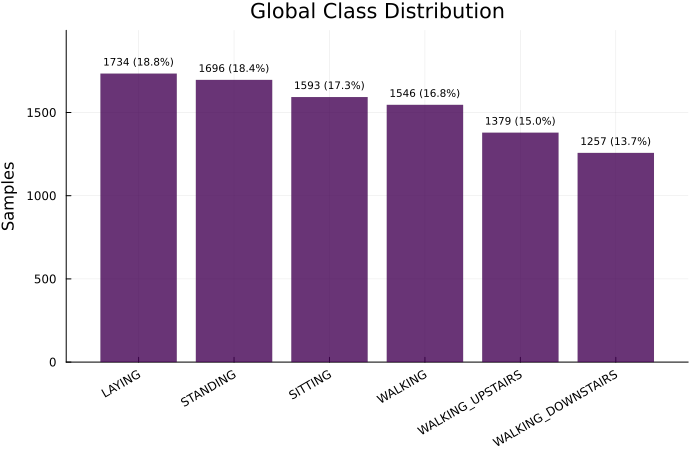

Imbalance Ratio: 1.38


In [15]:
# Métricas de desbalanceo
min_c, max_c = extrema(activity_counts.Count)
imbalance_ratio = max_c / min_c

# Preparar etiquetas con %
total_n = sum(activity_counts.Count)
pcts = round.((activity_counts.Count ./ total_n) * 100, digits=1)
bar_labels = string.(activity_counts.Count, " (", pcts, "%)")

# Visualización
p_global = bar(
    activity_counts.Activity, activity_counts.Count,
    title = "Global Class Distribution",
    xlabel = "Activity Class", ylabel = "Samples",
    color = :viridis, alpha = 0.8, legend = false,
    xrotation = 30, linewidth = 0,
    ylim = (0, max_c * 1.15), # Margen superior para etiquetas
    size = (700, 450)
)

# Anotaciones sobre barras
anns = [(x, y + (max_c*0.02), text(lbl, 7, :black, :bottom)) 
        for (x, y, lbl) in zip(activity_counts.Activity, activity_counts.Count, bar_labels)]
annotate!(anns)

display(p_global)
println("Imbalance Ratio: $(round(imbalance_ratio, digits=2))")

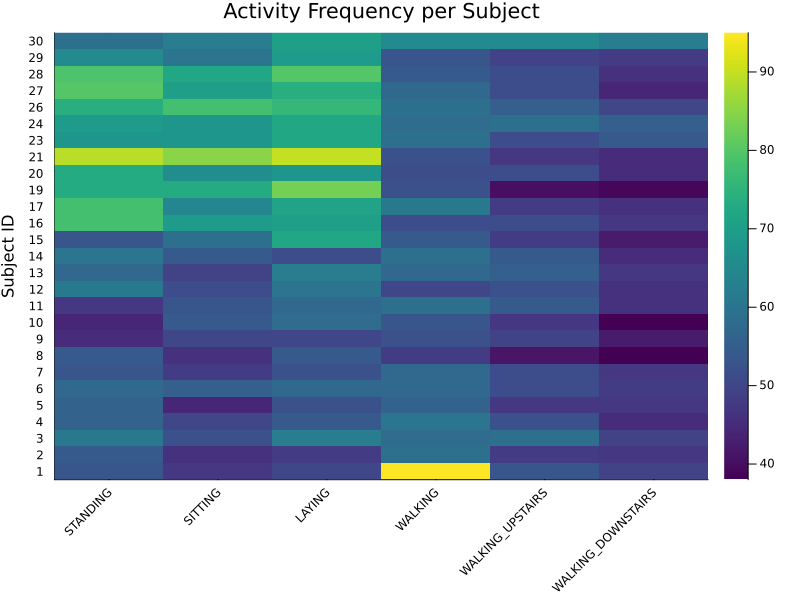

In [16]:
p_heatmap = heatmap(
    activities_x, subjects_categorical, heatmap_matrix,
    title  = "Activity Frequency per Subject",
    xlabel = "Activity", ylabel = "Subject ID",
    color = :viridis,
    xrotation = 45,
    size = (800, 600)
)

display(p_heatmap)

### **6. Conversión de datos para el pipeline**

Qué hacemos en esta fase del preprocesado:

- Convertir datos a **Tables** en lugar de DataFrames.
- Convertir el vector de labels a vector categórcio con **label encoding** 

In [15]:
# 1. Feature Extraction (X)
# Transformación a ColumnTable (NamedTuple de vectores) para eficiencia en memoria
data_tbl = Tables.columntable(train)

# Filtrado de columnas de metadatos (ID y Target)
ignore_cols = (:subject, :Activity)
feature_cols = filter(k -> k ∉ ignore_cols, keys(data_tbl))

# Construcción de X como NamedTuple limpia
X_train = NamedTuple{feature_cols}(data_tbl)

# 2. Target Encoding (y)
# Definición explícita de ordinalidad
activity_levels = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Conversión a CategoricalArray ordenado
# MLJ prefiere Categorical{String} con orden definido antes que raw Integers
y_raw = Tables.getcolumn(data_tbl, :Activity)
y_train = categorical(y_raw, levels=activity_levels, ordered=true)

# Sanity checks
println("X Type:      ", typeof(X_train))
println("y Scitype:   ", scitype(y_train)) # Verificar compatibilidad con MLJ (OrderedFactor)
println("y Levels:    ", levels(y_train))

X Type:      @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Float64}, var"tBodyAcc-entropy()-X"::Vector{Float64}, var"tBodyAcc-entropy()-Y"::Vector{Float64

In [16]:
# 1. Feature Extraction (X)
# Transformación a ColumnTable (NamedTuple de vectores) para eficiencia en memoria
data_tbl = Tables.columntable(test)

# Filtrado de columnas de metadatos (ID y Target)
ignore_cols = (:subject, :Activity)
feature_cols = filter(k -> k ∉ ignore_cols, keys(data_tbl))

# Construcción de X como NamedTuple limpia
X_test = NamedTuple{feature_cols}(data_tbl)

# 2. Target Encoding (y)
# Definición explícita de ordinalidad
activity_levels = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Conversión a CategoricalArray ordenado
y_raw = Tables.getcolumn(data_tbl, :Activity)
y_test = categorical(y_raw, levels=activity_levels, ordered=true)

# Sanity checks
println("X Type:      ", typeof(X_test))
println("y Scitype:   ", scitype(y_test)) # Verificar compatibilidad con MLJ (OrderedFactor)
println("y Levels:    ", levels(y_test))

X Type:      @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Float64}, var"tBodyAcc-entropy()-X"::Vector{Float64}, var"tBodyAcc-entropy()-Y"::Vector{Float64

## **Visualización de los datos**

## **Entrenamiento y evaluación de clasificadores**

In [17]:
include("../src/filterWrappers.jl")
include("../src/dimReduction.jl")
include("../src/modelFactory.jl")
include("../src/experimentLab.jl")
include("../src/scaler.jl")
include("../src/resultAnalysis.jl")
include("../src/hypothesisTest.jl")

using .FilteringReduction: PearsonSelector, SpearmanSelector, KendallSelector, ANOVASelector, MutualInfoSelector, RFELogistic
using .ProyectionReduction: get_lda_model, get_pca_model, get_ica_model
using .ModelFactory: get_knn_model, 
                        get_svm_model, 
                        get_mlp_model, 
                        get_bagging_knn_model, 
                        get_evotree_model, 
                        get_adaboost_model, 
                        get_rf_model, 
                        get_xgboost_model, 
                        get_lightgbm_model, 
                        get_catboost_model,
                        get_voting_classifier,
                        get_stacking_model,
                        get_individual_wise_CV,
                        IndividualWiseCV

using .ExperimentLab: run_experiment_crossvalidation, History, run_experiment_holdout
using .CustomScalers: MinMaxScaler
using .ResultAnalysis: display_cv_table, plot_cv_results, display_holdout_table
using .StatisticalTests: auto_compare_models

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


[ Info: lib_lightgbm found in system dirs!
    CondaPkg Found dependencies: /Users/rafa/.julia/packages/CondaPkg/0UqYV/CondaPkg.toml
    CondaPkg Found dependencies: /Users/rafa/.julia/packages/PythonCall/wkBj7/CondaPkg.toml
    CondaPkg Found dependencies: /Users/rafa/.julia/packages/CatBoost/9RVr2/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/rafa/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/rafa/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg
✔ Created /Users/rafa/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/rafa/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/pixi.toml
             │ [dependencies]
             │ openssl = ">=3, <3.6"
             │ catboost = ">=1.1"
             │ 
             │     [d

In [18]:
SCALER = MinMaxScaler()
METRICS = Dict(
    "Accuracy" => Accuracy(),
    "F1_Macro" => MulticlassFScore(beta=1.0, average=MacroAvg())
)

Dict{String, StatisticalMeasuresBase.FussyMeasure{M, Nothing} where M} with 2 entries:
  "Accuracy" => Accuracy()
  "F1_Macro" => MulticlassFScore(beta = 1.0, …)

In [19]:
function run_scenarios_cv(scenarios)

    results = History[]

    for (tag, filter, reducer, model) in scenarios
        try
            history = run_experiment_crossvalidation(
                SCALER, 
                filter, 
                reducer, 
                model, 
                X_train, y_train, folds;
                tag = tag, 
                metrics = METRICS
            )

            push!(results, history)
        catch e
            println("Error en el escenario: $tag")
            println(e)
        end
    end

    # Mostrar resultados
    display_cv_table(results, ["Accuracy", "F1_Macro"])

    p = plot_cv_results(results, "F1_Macro")
    display(p)

    return results

end

run_scenarios_cv (generic function with 1 method)

In [20]:
function run_scenarios_holdout(scenarios)

    results = History[]

    for (tag, filter, reducer, model) in scenarios
        try
            history = run_experiment_holdout(
                SCALER, 
                filter, 
                reducer, 
                model, 
                X_train, y_train,
                X_test, y_test;
                tag = tag, 
                metrics = METRICS
            )

            push!(results, history)
        catch e
            println("Error en el escenario: $tag")
            println(e)
        end
    end

    # Mostrar resultados
    display_holdout_table(results, ["Accuracy", "F1_Macro"])

    return results

end

run_scenarios_holdout (generic function with 1 method)

## **Modelos básicos**

### **1. K Nearest Neighbors**

Exp: KNN_1_ANOVA_PCA   Dims: {505} -> {100.0 ± 0.0} -> {21.4 ± 0.5}   Accuracy: 0.817   F1_Macro: 0.812
Exp: KNN_10_MI_LDA   Dims: {505} -> {100.0 ± 0.0} -> {5.0 ± 0.0}   Accuracy: 0.817   F1_Macro: 0.827
Exp: KNN_20_kendall   Dims: {505} -> {100.0 ± 0.0} -> {100.0 ± 0.0}   Accuracy: 0.745   F1_Macro: 0.756
┌─────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment      │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├─────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ KNN_10_MI_LDA   │ 0.8170          │ 0.0337         │ 0.8266          │ 0.0320         │
│ KNN_1_ANOVA_PCA │ 0.8166          │ 0.0085         │ 0.8122          │ 0.0099         │
│ KNN_20_kendall  │ 0.7454          │ 0.0093         │ 0.7556          │ 0.0110         │
└─────────────────┴─────────────────┴────────────────┴─────────────────┴────────────────┘


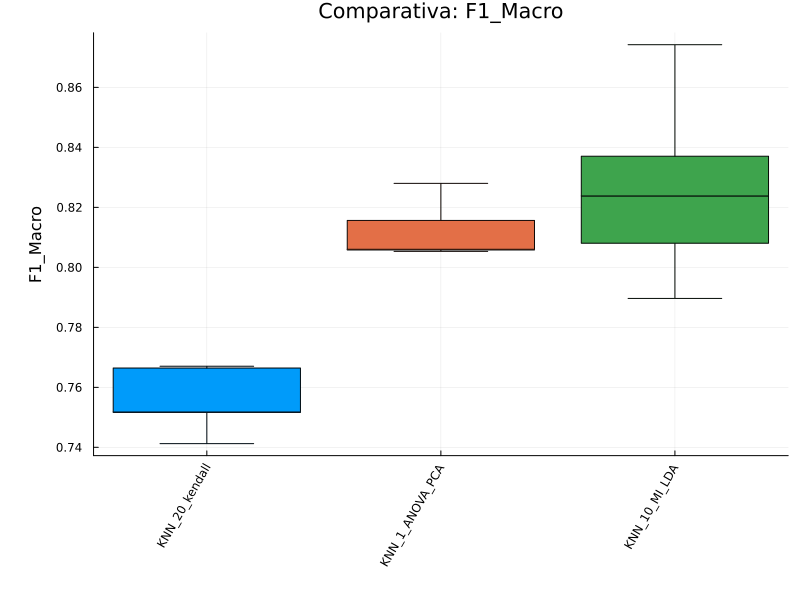

In [20]:
SCENARIOS_KNN = [
    ("KNN_1_ANOVA_PCA", ANOVASelector(k = 100), get_pca_model(pratio=0.95), get_knn_model(1)),
    ("KNN_10_MI_LDA", MutualInfoSelector(k = 100), get_lda_model(outdim=5), get_knn_model(10)),
    ("KNN_20_kendall", KendallSelector(k=100), nothing, get_knn_model(20)), 
]

resuls_knn = run_scenarios_cv(SCENARIOS_KNN);

In [21]:
auto_compare_models(resuls_knn, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00752
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: KNN_10_MI_LDA (Media: 0.8266)
┌─────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo          │ Media  │ Diferencia │ P_Value │ Significativo │
├─────────────────┼────────┼────────────┼─────────┼───────────────┤
│ KNN_1_ANOVA_PCA │ 0.8122 │ 0.0144     │ 0.28635 │ No            │
│ KNN_20_kendall  │ 0.7556 │ 0.0709     │ 0.00726 │ Si            │
└─────────────────┴────────┴────────────┴─────────┴───────────────┘


┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


### **2. Multilayer Perceptron**

Exp: MLP_[50]_Pearson_PCA   Dims: {505} -> {400.0 ± 0.0} -> {28.8 ± 0.8}   Accuracy: 0.918   F1_Macro: 0.917
Exp: MLP_[100]_Spearman_ICA   Dims: {505} -> {25.0 ± 0.0} -> {10.0 ± 0.0}   Accuracy: 0.658   F1_Macro: 0.668
Exp: MLP_[100, 50]_baseline   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.926   F1_Macro: 0.925
┌────────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment             │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ MLP_[100, 50]_baseline │ 0.9261          │ 0.0331         │ 0.9249          │ 0.0352         │
│ MLP_[50]_Pearson_PCA   │ 0.9177          │ 0.0199         │ 0.9175          │ 0.0187         │
│ MLP_[100]_Spearman_ICA │ 0.6583          │ 0.0324         │ 0.6677          │ 0.0374         │
└────────────────────────┴─────────────────┴────────────────┴─────────────────┴────────

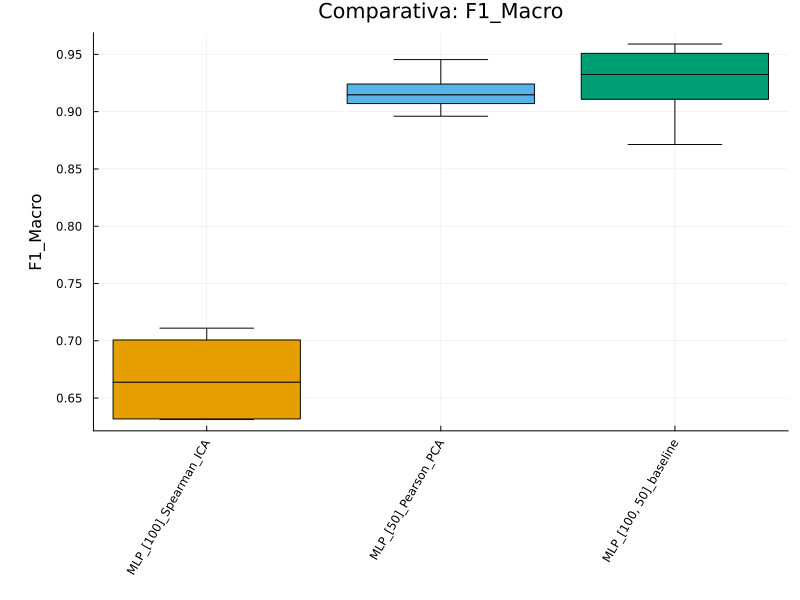

3-element Vector{History}:
 History("MLP_[50]_Pearson_PCA", Dict{String, Any}("Accuracy" => [0.8949792722247812, 0.906522855675398, 0.9259462424574877, 0.9139590854392299, 0.9469413233458177], "F1_Macro" => [0.8959956790622176, 0.9070656069905426, 0.9241248507921681, 0.9148343131847707, 0.9454608510360845]), 505, (400.0, 0.0), (28.8, 0.8366600265340756))
 History("MLP_[100]_Spearman_ICA", Dict{String, Any}("Accuracy" => [0.696453247351451, 0.6291730868002054, 0.6582556226001097, 0.6233453670276775, 0.6841448189762797], "F1_Macro" => [0.7110223465470089, 0.6317739871707232, 0.6638770705782379, 0.6312244413103004, 0.7007267506634614]), 505, (25.0, 0.0), (10.0, 0.0))
 History("MLP_[100, 50]_baseline", Dict{String, Any}("Accuracy" => [0.90879778903731, 0.9316897791474062, 0.9594075699396599, 0.8784596871239471, 0.9519350811485643], "F1_Macro" => [0.91081567255683, 0.9324386166857447, 0.9590457350139728, 0.8713376869423727, 0.9508823436070816]), 505, (505.0, 0.0), (505.0, 0.0))

In [ ]:
SCENARIOS_MLP = [
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(pratio=0.95), get_mlp_model([50]; epochs=30)),
    ("MLP_[100]_Spearman_ICA", SpearmanSelector(k = 25), get_ica_model(outdim=10, maxiter=10000, tol=0.5), get_mlp_model([100]; epochs=30)),
    ("MLP_[100, 50]_baseline", nothing, nothing, get_mlp_model([100, 50]; epochs=30)), 
]

results_mlp = run_scenarios_cv(SCENARIOS_MLP);

In [26]:
auto_compare_models(results_mlp, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00815
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: MLP_[100, 50]_baseline (Media: 0.9249)
┌────────────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo                 │ Media  │ Diferencia │ P_Value │ Significativo │
├────────────────────────┼────────┼────────────┼─────────┼───────────────┤
│ MLP_[50]_Pearson_PCA   │ 0.9175 │ 0.0074     │ 0.61632 │ No            │
│ MLP_[100]_Spearman_ICA │ 0.6677 │ 0.2572     │ 0.00016 │ Si            │
└────────────────────────┴────────┴────────────┴─────────┴───────────────┘



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


### **3. Suport Vector Machine**

Exp: SVM_01_RFE_LDA   Dims: {505} -> {100.0 ± 0.0} -> {5.0 ± 0.0}   Accuracy: 0.888   F1_Macro: 0.877
Exp: SVM_05_PEARSON_PCA   Dims: {505} -> {250.0 ± 0.0} -> {8.0 ± 0.0}   Accuracy: 0.881   F1_Macro: 0.878
Exp: SVM_1_MI_PCA   Dims: {505} -> {400.0 ± 0.0} -> {79.2 ± 2.5}   Accuracy: 0.934   F1_Macro: 0.934
┌────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment         │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ SVM_1_MI_PCA       │ 0.9338          │ 0.0187         │ 0.9337          │ 0.0182         │
│ SVM_01_RFE_LDA     │ 0.8878          │ 0.0576         │ 0.8773          │ 0.0810         │
│ SVM_05_PEARSON_PCA │ 0.8814          │ 0.0282         │ 0.8779          │ 0.0284         │
└────────────────────┴─────────────────┴────────────────┴─────────────────┴────────────────┘


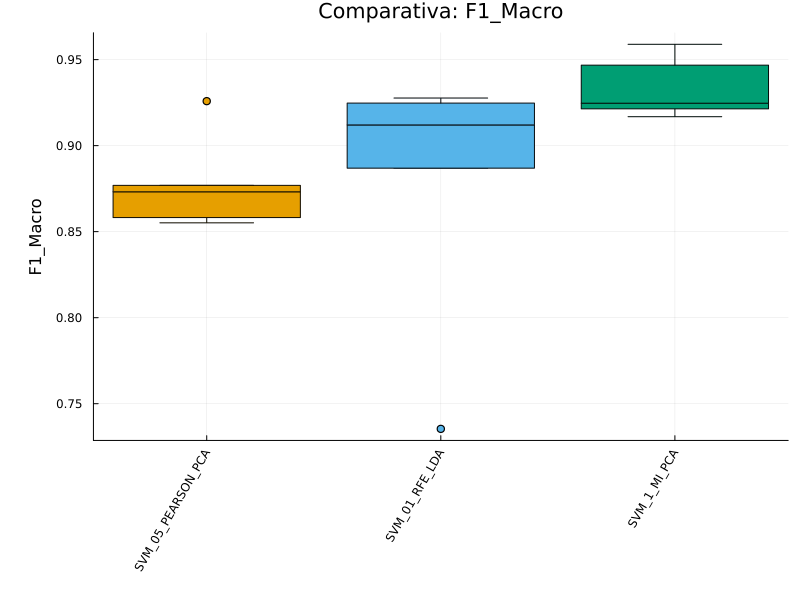

3-element Vector{History}:
 History("SVM_01_RFE_LDA", Dict{String, Any}("Accuracy" => [0.8862275449101796, 0.9270672829994864, 0.9232035106966539, 0.7888086642599278, 0.9138576779026217], "F1_Macro" => [0.8869164473247989, 0.9276559695893202, 0.9247207908779131, 0.7353570601907359, 0.912048761522156]), 505, (100.0, 0.0), (5.0, 0.0))
 History("SVM_05_PEARSON_PCA", Dict{String, Any}("Accuracy" => [0.8747121142330723, 0.8582434514637904, 0.929786066922655, 0.8790613718411552, 0.8651685393258427], "F1_Macro" => [0.8731908510737942, 0.8581945753885105, 0.9258595601230001, 0.8768961959081296, 0.8551357507807135]), 505, (250.0, 0.0), (8.0, 0.0))
 History("SVM_1_MI_PCA", Dict{String, Any}("Accuracy" => [0.9203132197144174, 0.9167950693374423, 0.9594075699396599, 0.9247894103489771, 0.947565543071161], "F1_Macro" => [0.9213794866928081, 0.9168208236704022, 0.9589110339360476, 0.9246447920616179, 0.9467724524689628]), 505, (400.0, 0.0), (79.2, 2.4899799195977463))

In [ ]:
SCENARIOS_SVM = [
    ("SVM_01_RFE_LDA", RFELogistic(k = 100, step=0.5), get_lda_model(outdim=5), get_svm_model(0.1)),
    ("SVM_05_PEARSON_PCA", PearsonSelector(k = 250), get_pca_model(pratio=0.95), get_svm_model(0.5)),
    ("SVM_1_MI_PCA", MutualInfoSelector(k = 400), get_pca_model(pratio=0.98), get_svm_model(1.0)), 
]

results_svm = run_scenarios_cv(SCENARIOS_SVM);

In [28]:
auto_compare_models(results_svm, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.10228
Resultado: No se rechaza H0.



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


## **Modelos de ensemble básicos**

### **1. Bagging con kNN**

Exp: BAGGING_KNN_10   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.901   F1_Macro: 0.9
Exp: BAGGING_KNN_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.905   F1_Macro: 0.904
Exp: BAGGING_KNN_PCA_10   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.893   F1_Macro: 0.892
Exp: BAGGING_KNN_PCA_50   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.9   F1_Macro: 0.899
┌────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment         │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ BAGGING_KNN_50     │ 0.9047          │ 0.0104         │ 0.9040          │ 0.0114         │
│ BAGGING_KNN_10     │ 0.9008          │ 0.0108         │ 0.9000          │ 0.0119         │
│ BAGGING_KNN_PCA_50 │ 0.8996          │ 0.0098         │ 0.8988          │ 0.0106         │
│ BAGGING_KNN_PCA_10 │ 0

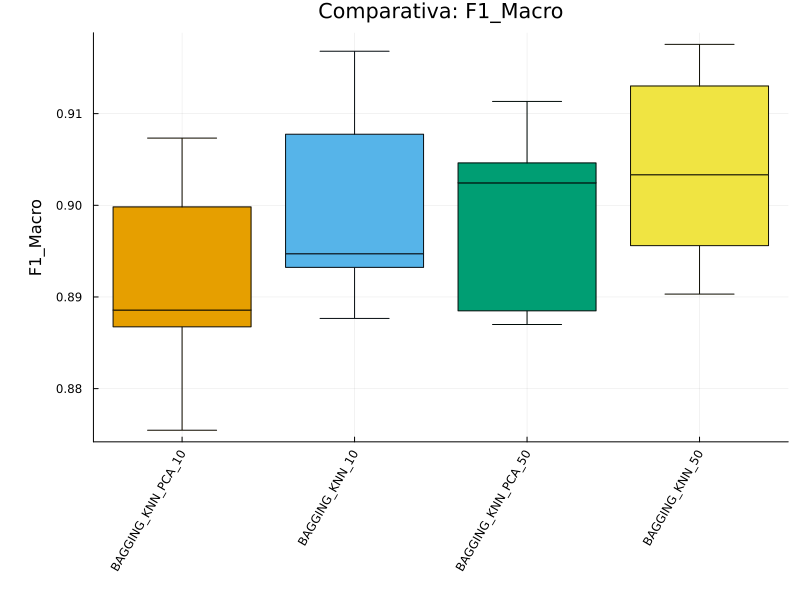

4-element Vector{History}:
 History("BAGGING_KNN_10", Dict{String, Any}("Accuracy" => [0.8926761860893597, 0.9157678479712378, 0.8957761930883159, 0.9085439229843562, 0.8913857677902621], "F1_Macro" => [0.8932299201448348, 0.9168074578752214, 0.8947175344634246, 0.9077539041852317, 0.8876592783234915]), 505, (505.0, 0.0), (505.0, 0.0))
 History("BAGGING_KNN_50", Dict{String, Any}("Accuracy" => [0.8949792722247812, 0.9167950693374423, 0.904552934722984, 0.9133574007220217, 0.8938826466916354], "F1_Macro" => [0.8955985423850309, 0.9175627596122137, 0.9033379682606478, 0.9130230442285816, 0.8903117636721596]), 505, (505.0, 0.0), (505.0, 0.0))
 History("BAGGING_KNN_PCA_10", Dict{String, Any}("Accuracy" => [0.8862275449101796, 0.906522855675398, 0.8902907295666483, 0.9001203369434416, 0.8795255930087391], "F1_Macro" => [0.8867434305127142, 0.9073350913282924, 0.8885680900857871, 0.8998300793276702, 0.8754582436547159]), 505, (505.0, 0.0), (64.4, 0.8944271909999159))
 History("BAGGING_KNN_PC

In [ ]:
SCENARIOS_BAGGING = [
    ("BAGGING_KNN_10", nothing, nothing, get_bagging_knn_model(5, 10; fraction=0.7)),
    ("BAGGING_KNN_50", nothing, nothing, get_bagging_knn_model(5, 50; fraction=0.5)),
    ("BAGGING_KNN_PCA_10", nothing, get_pca_model(pratio=0.95), get_bagging_knn_model(5, 10; fraction=0.7)),
    ("BAGGING_KNN_PCA_50", nothing, get_pca_model(pratio=0.95), get_bagging_knn_model(5, 50; fraction=0.5))
]

resuls_bagging = run_scenarios_cv(SCENARIOS_BAGGING);

In [30]:
auto_compare_models(resuls_bagging, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.36098
Resultado: No se rechaza H0.



### **2. AdaBoost con Decision Trees**

Exp: ADABOOST_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.677   F1_Macro: 0.604
Exp: ADABOOST_50_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.65   F1_Macro: 0.624
Exp: ADABOOST_100   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.706   F1_Macro: 0.65
Exp: ADABOOST_100_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.631   F1_Macro: 0.624
Exp: ADABOOST_200   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.698   F1_Macro: 0.631
Exp: ADABOOST_200_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.7   F1_Macro: 0.68
┌──────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment       │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├──────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ ADABOOST_100     │ 0.7063          │ 0.0707         │ 0.6503          │ 0.0908         │
│ ADABOOST_200_PCA │ 0

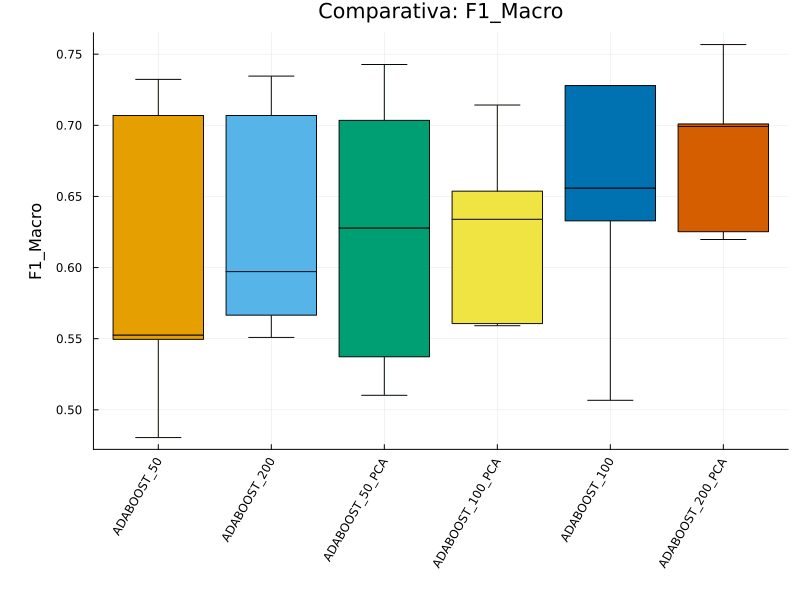

6-element Vector{History}:
 History("ADABOOST_50", Dict{String, Any}("Accuracy" => [0.7779824965453708, 0.6363636363636364, 0.7553483269336259, 0.6516245487364621, 0.5624219725343321], "F1_Macro" => [0.7322611194929246, 0.549554571758357, 0.7069051913129127, 0.5526219532933607, 0.48050832954185607]), 505, (505.0, 0.0), (505.0, 0.0))
 History("ADABOOST_50_PCA", Dict{String, Any}("Accuracy" => [0.7171810225702441, 0.578839239856189, 0.5458036204059243, 0.7430806257521059, 0.6660424469413233], "F1_Macro" => [0.7034793106217571, 0.5102249089867494, 0.5373027081511308, 0.7427287145377856, 0.6278855067384157]), 505, (505.0, 0.0), (64.4, 0.8944271909999159))
 History("ADABOOST_100", Dict{String, Any}("Accuracy" => [0.7673883003224321, 0.7139188495120699, 0.7652221612726275, 0.5944645006016848, 0.6903870162297129], "F1_Macro" => [0.727993096873492, 0.6559421299053427, 0.7279291087913105, 0.5067238512498017, 0.632828969508884]), 505, (505.0, 0.0), (505.0, 0.0))
 History("ADABOOST_100_PCA", Dict

In [ ]:
SCENARIOS_ADABOOST = [
    ("ADABOOST_50", nothing, nothing, get_adaboost_model(50)),
    ("ADABOOST_50_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(50)),
    ("ADABOOST_100", nothing, nothing, get_adaboost_model(100)),
    ("ADABOOST_100_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(100)),
    ("ADABOOST_200", nothing, nothing, get_adaboost_model(200)),
    ("ADABOOST_200_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(200))
]

results_adaboost = run_scenarios_cv(SCENARIOS_ADABOOST);

In [36]:
auto_compare_models(results_adaboost, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.89995
Resultado: No se rechaza H0.



### **3. EvoTree (Gradient Boosting)**

Exp: EVOTREE_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.919   F1_Macro: 0.918
Exp: EVOTREE_100   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.927   F1_Macro: 0.927
Exp: EVOTREE_50_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.863   F1_Macro: 0.862
Exp: EVOTREE_100_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.884   F1_Macro: 0.883
┌─────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment      │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├─────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ EVOTREE_100     │ 0.9270          │ 0.0157         │ 0.9267          │ 0.0155         │
│ EVOTREE_50      │ 0.9186          │ 0.0148         │ 0.9182          │ 0.0147         │
│ EVOTREE_100_PCA │ 0.8838          │ 0.0202         │ 0.8829          │ 0.0205         │
│ EVOTREE_50_PCA  │ 0.8632          │ 0.0234        

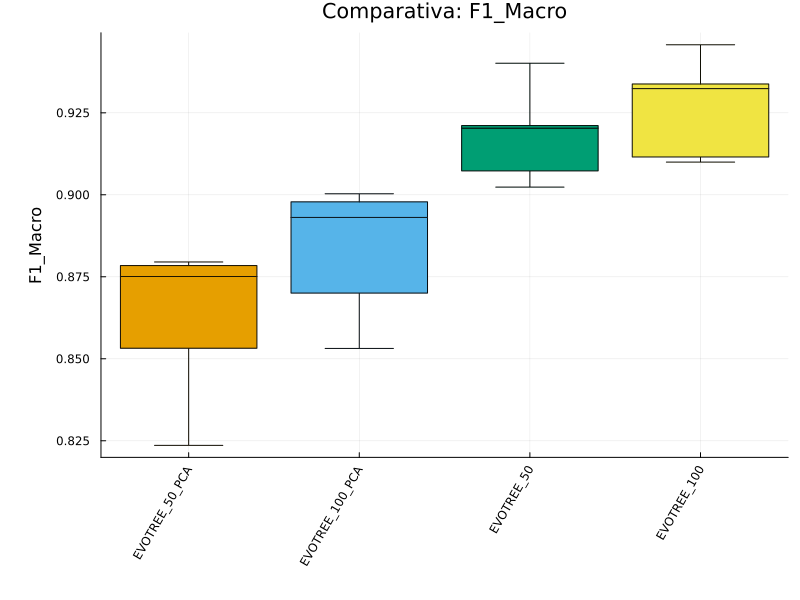

4-element Vector{History}:
 History("EVOTREE_50", Dict{String, Any}("Accuracy" => [0.9207738369415016, 0.901386748844376, 0.9396599012616567, 0.907942238267148, 0.9232209737827716], "F1_Macro" => [0.9203237634441287, 0.9023374227818224, 0.9401160644565323, 0.9072945761752558, 0.9211006777765793]), 505, (505.0, 0.0), (505.0, 0.0))
 History("EVOTREE_100", Dict{String, Any}("Accuracy" => [0.9327498848456932, 0.9090909090909091, 0.945693911135491, 0.9121540312876053, 0.9350811485642946], "F1_Macro" => [0.932393984035697, 0.9099707726949232, 0.9457406434883213, 0.911534884121038, 0.9337850645143067]), 505, (505.0, 0.0), (505.0, 0.0))
 History("EVOTREE_50_PCA", Dict{String, Any}("Accuracy" => [0.8544449562413634, 0.8767334360554699, 0.8793198025233132, 0.8796630565583634, 0.8258426966292135], "F1_Macro" => [0.8532080396787911, 0.8784139007713629, 0.8750878631013435, 0.8795110692943962, 0.8235986036792309]), 505, (505.0, 0.0), (64.4, 0.8944271909999159))
 History("EVOTREE_100_PCA", Dict{Strin

In [ ]:
SCENARIOS_EVOTREE = [
    ("EVOTREE_50", nothing, nothing, get_evotree_model(50)),
    ("EVOTREE_100", nothing, nothing, get_evotree_model(100)),
    ("EVOTREE_50_PCA", nothing, get_pca_model(pratio=0.95), get_evotree_model(50)),
    ("EVOTREE_100_PCA", nothing, get_pca_model(pratio=0.95), get_evotree_model(100))
]   

results_evotree = run_scenarios_cv(SCENARIOS_EVOTREE)

In [ ]:
auto_compare_models(results_evotree, "F1_Macro")                                      


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00194
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: EVOTREE_100 (Media: 0.9267)
┌─────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo          │ Media  │ Diferencia │ P_Value │ Significativo │
├─────────────────┼────────┼────────────┼─────────┼───────────────┤
│ EVOTREE_50      │ 0.9182 │ 0.0085     │ 0.00755 │ Si            │
│ EVOTREE_100_PCA │ 0.8829 │ 0.0438     │ 0.03001 │ Si            │
│ EVOTREE_50_PCA  │ 0.8620 │ 0.0647     │ 0.01241 │ Si            │
└─────────────────┴────────┴────────────┴─────────┴───────────────┘



## **Entrenamiento con holdout**

In [22]:
SCENARIOS_HOLDOUT_BASIC = [
    ("KNN_1_ANOVA_PCA", ANOVASelector(k = 100), get_pca_model(pratio=0.95), get_knn_model(1)),
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(pratio=0.95), get_mlp_model([50]; epochs=30)),
    ("SVM_05_PEARSON_PCA", PearsonSelector(k = 250), get_pca_model(pratio=0.95), get_svm_model(0.5)),
    ("BAGGING_KNN_10", nothing, nothing, get_bagging_knn_model(5, 10; fraction=0.7)),
    ("ADABOOST_50_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(50)),
    ("EVOTREE_100", nothing, nothing, get_evotree_model(100))
]

results_holdout_basic = run_scenarios_holdout(SCENARIOS_HOLDOUT_BASIC);


Exp: KNN_1_ANOVA_PCA   Dims: {505} -> {100} -> {22}   Accuracy: 0.7989   F1_Macro: 0.7729
Exp: MLP_[50]_Pearson_PCA   Dims: {505} -> {400} -> {29}   Accuracy: 0.8995   F1_Macro: 0.8894
Exp: SVM_05_PEARSON_PCA   Dims: {505} -> {250} -> {8}   Accuracy: 0.8483   F1_Macro: 0.8191
Exp: BAGGING_KNN_10   Dims: {505} -> {505} -> {505}   Accuracy: 0.8739   F1_Macro: 0.8469
Exp: ADABOOST_50_PCA   Dims: {505} -> {505} -> {65}   Accuracy: 0.5046   F1_Macro: 0.4215
Exp: EVOTREE_100   Dims: {505} -> {505} -> {505}   Accuracy: 0.8711   F1_Macro: 0.8468
┌──────────────────────┬──────────┬──────────┐
│ Experiment           │ Accuracy │ F1_Macro │
├──────────────────────┼──────────┼──────────┤
│ MLP_[50]_Pearson_PCA │ 0.8995   │ 0.8894   │
│ BAGGING_KNN_10       │ 0.8739   │ 0.8469   │
│ EVOTREE_100          │ 0.8711   │ 0.8468   │
│ SVM_05_PEARSON_PCA   │ 0.8483   │ 0.8191   │
│ KNN_1_ANOVA_PCA      │ 0.7989   │ 0.7729   │
│ ADABOOST_50_PCA      │ 0.5046   │ 0.4215   │
└──────────────────────┴─────────

## **Modelos de Ensemble Avanzado**

### **1. Random Forest**

In [23]:
SCENARIOS_RF = [
    ("RANDOM_FOREST", nothing, nothing, get_rf_model(500, 10))
]

results_rf = run_scenarios_holdout(SCENARIOS_RF);

Exp: RANDOM_FOREST   Dims: {505} -> {505} -> {505}   Accuracy: 0.8711   F1_Macro: 0.8447
┌───────────────┬──────────┬──────────┐
│ Experiment    │ Accuracy │ F1_Macro │
├───────────────┼──────────┼──────────┤
│ RANDOM_FOREST │ 0.8711   │ 0.8447   │
└───────────────┴──────────┴──────────┘


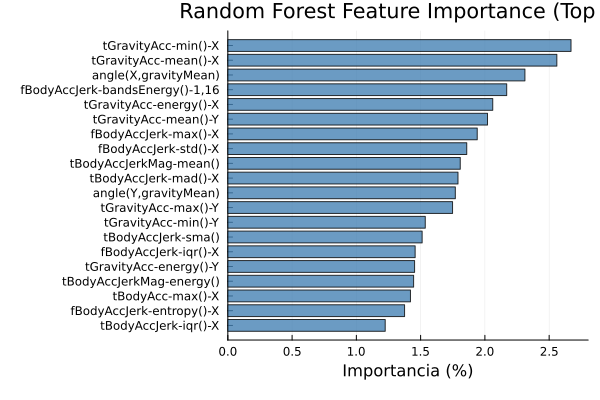

In [24]:
using Plots
using Plots.Measures

history = results_rf[1]
fi = history.feature_importances

# 1. PREPARACIÓN DE DATOS
sort!(fi, by = x -> last(x), rev = false) 
top_n = 20
fi_subset = last(fi, min(length(fi), top_n))
names = string.(first.(fi_subset))
values_raw = last.(fi_subset)

# NORMALIZACIÓN A PORCENTAJE
# Calculamos el porcentaje respecto al TOTAL de todas las features (no solo las top 50)
total_importance = sum(last.(fi))
values = (values_raw ./ total_importance) .* 100  # Convertir a porcentaje

# 2. GRAFICADO CORRECTO
positions = 1:length(values)

p = bar(
    positions,
    values,
    orientation = :h,           
    yticks = (positions, names),
    legend = false,
    color = :steelblue,
    alpha = 0.8,
    left_margin = 3mm,
    bottom_margin = 5mm,
    title = "Random Forest Feature Importance (Top 50)",
    xlabel = "Importancia (%)",  # Cambiado a porcentaje
    ylabel = "",
    grid = :x,
    xlims = (0, maximum(values) * 1.05)
)

display(p)

### **2. XG Boost**

In [25]:
SCENARIOS_XG_BOOST = [
    ("XG_BOOST", nothing, nothing, get_xgboost_model(500))
]

results_xg_boost = run_scenarios_holdout(SCENARIOS_XG_BOOST);

Exp: XG_BOOST   Dims: {505} -> {505} -> {505}   Accuracy: 0.9186   F1_Macro: 0.9039
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ XG_BOOST   │ 0.9186   │ 0.9039   │
└────────────┴──────────┴──────────┘


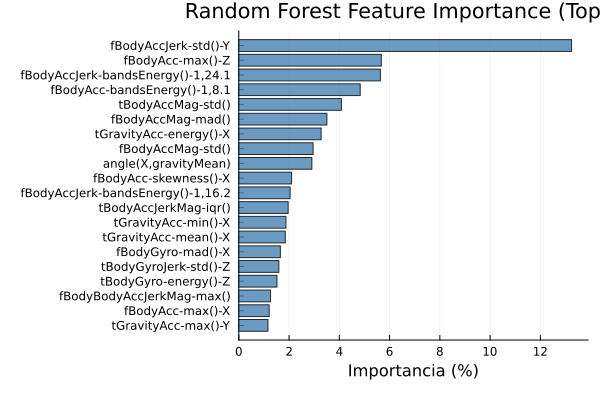

In [26]:
using Plots
using Plots.Measures

history = results_xg_boost[1]
fi = history.feature_importances

# 1. PREPARACIÓN DE DATOS
sort!(fi, by = x -> last(x), rev = false) 
top_n = 20
fi_subset = last(fi, min(length(fi), top_n))
names = string.(first.(fi_subset))
values_raw = last.(fi_subset)

# NORMALIZACIÓN A PORCENTAJE
# Calculamos el porcentaje respecto al TOTAL de todas las features (no solo las top 50)
total_importance = sum(last.(fi))
values = (values_raw ./ total_importance) .* 100  # Convertir a porcentaje

# 2. GRAFICADO CORRECTO
positions = 1:length(values)

p = bar(
    positions,
    values,
    orientation = :h,           
    yticks = (positions, names),
    legend = false,
    color = :steelblue,
    alpha = 0.8,
    left_margin = 3mm,
    bottom_margin = 5mm,
    title = "Random Forest Feature Importance (Top 50)",
    xlabel = "Importancia (%)",  # Cambiado a porcentaje
    ylabel = "",
    grid = :x,
    xlims = (0, maximum(values) * 1.05)
)

display(p)


### **3. LightGBM**

In [27]:
SCENARIOS_LGBM = [
    ("LGBM", nothing, nothing, get_lightgbm_model(100))
]

results_lgbm = run_scenarios_holdout(SCENARIOS_LGBM);

Exp: LGBM   Dims: {505} -> {505} -> {505}   Accuracy: 0.8976   F1_Macro: 0.8833
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ LGBM       │ 0.8976   │ 0.8833   │
└────────────┴──────────┴──────────┘


### **4. CatBoost**

In [21]:
SCENARIOS_CAT_BOOST = [
    ("CAT_BOOST", nothing, nothing, get_catboost_model())
]

results_cat_boost = run_scenarios_holdout(SCENARIOS_CAT_BOOST);

┌ Error: Problem fitting the machine machine(:classifier, …). 
└ @ MLJBase ~/.julia/packages/MLJBase/7nGJF/src/machines.jl:694
[ Info: Running type checks... 
[ Info: Type checks okay. 
┌ Error: Problem fitting machine(:classifier, …)
└ @ MLJBase ~/.julia/packages/MLJBase/7nGJF/src/machines.jl:766
┌ Error: Problem fitting the machine machine(FlexiblePipeline(scaler = MinMaxScaler(), …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/7nGJF/src/machines.jl:694
[ Info: Running type checks... 
[ Info: Type checks okay. 


Error en el escenario: CAT_BOOST
CompositeException(Any[TaskFailedException(Task (failed) @0x00000003500b7a30)])
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
└────────────┴──────────┴──────────┘


In [1]:
using MLJ, CatBoost

const MLJ_CatBoost = @load CatBoostClassifier pkg=CatBoost verbosity=0

X = (a = [1.0, 2.0, 3.0, 4.0], b = [4.0, 5.0, 6.0, 7.0])
y = coerce(["A", "B", "A", "B"], Multiclass)

model = MLJ_CatBoost(thread_count=1, task_type="CPU", iterations=5)
mach = machine(model, X, y)

try
    MLJ.fit!(mach, verbosity=0)
catch e
    showerror(stdout, e)
end

Python: ValueError: NoneType copy mode not allowed.

In [15]:
using CatBoost.MLJCatBoostInterface
using DataFrames
using MLJBase

# Initialize data
train_data = DataFrame([[1, 4, 30], [4, 5, 40], [5, 6, 50], [6, 7, 60]], :auto)
train_labels = [10.0, 20.0, 30.0]
eval_data = DataFrame([[2, 1], [4, 4], [6, 50], [8, 60]], :auto)

# Initialize CatBoostClassifier
model = CatBoost.MLJCatBoostInterface.CatBoostRegressor(; iterations=2, learning_rate=1.0, depth=2)
mach = machine(model, train_data, train_labels)

# Fit model
MLJBase.fit!(mach)

# Get predictions
preds_class = MLJBase.predict(mach, eval_data)

[ Info: Training machine(CatBoostRegressor(iterations = 2, …), …).


2-element Vector{Float64}:
 15.625
 18.125

In [12]:
using CatBoost.MLJCatBoostInterface
using DataFrames
using MLJBase

# Initialize data
train_data = DataFrame([coerce(["a", "a", "c"], MLJBase.Multiclass),
                        coerce(["b", "b", "d"], MLJBase.Multiclass),
                        coerce([0, 0, 1], MLJBase.OrderedFactor), [4, 5, 40], [5, 6, 50],
                        [6, 7, 60]], :auto)
train_labels = coerce([1, 0, -1], MLJBase.Multiclass)
eval_data = DataFrame([coerce(["a", "a"], MLJBase.Multiclass),
                       coerce(["b", "d"], MLJBase.Multiclass), [2, 1], [4, 4], [6, 50],
                       [8, 60]], :auto)

# Initialize CatBoostClassifier
model = CatBoost.MLJCatBoostInterface.CatBoostClassifier(; iterations=2, learning_rate=1, depth=2)
mach = machine(model, train_data, train_labels)

# Fit model
MLJBase.fit!(mach)

# Get predicted classes
preds_class = MLJBase.predict_mode(mach, eval_data)

# Get predicted probabilities for each class
preds_proba = MLJBase.predict(mach, eval_data)

LoadError: Python: ValueError: NoneType copy mode not allowed.
[0mPython stacktrace:
[0m [1] [0m[1m__array__[22m
[90m   @ [39m[90m~/.julia/packages/PythonCall/wkBj7/src/JlWrap/array.jl:371[39m
[0m [2] [0m[1m__new__[22m
[90m   @ [39m[32mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:529[39m
[0m [3] [0m[1m_with_infer[22m
[90m   @ [39m[32mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:681[39m
[0m [4] [0m[1mvalidate_categories[22m
[90m   @ [39m[32mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:572[39m
[0m [5] [0m[1m_finalize[22m
[90m   @ [39m[32mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:378[39m
[0m [6] [0m[1m__init__[22m
[90m   @ [39m[32mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:221[39m
[0m [7] [0m[1m_from_values_or_dtype[22m
[90m   @ [39m[32mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:338[39m
[0m [8] [0m[1mfrom_codes[22m
[90m   @ [39m[32mpandas.core.arrays.categorical [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/arrays/categorical.py:746[39m

### **5. Hard Voting con SVM**

In [28]:
SCENARIOS_SVM_VOTING = [
    ("SVM_VOTING", nothing, nothing, get_voting_classifier(0.5, 3))
]

results_svm_voting = run_scenarios_holdout(SCENARIOS_SVM_VOTING);

Exp: SVM_VOTING   Dims: {505} -> {505} -> {505}   Accuracy: 0.9086   F1_Macro: 0.8894
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ SVM_VOTING │ 0.9086   │ 0.8894   │
└────────────┴──────────┴──────────┘


### **6. Stacking Ensemble**

In [29]:
base_models = Dict(
    :knn => get_knn_model(1),
    :svm => get_svm_model(0.5),
    :mlp => get_mlp_model([50]; epochs=30)
)

meta_learner = get_mlp_model([20]; epochs=20)

resampling_strategy = IndividualWiseCV(folds)

stacking_model = get_stacking_model(meta_learner,
                                    base_models, 
                                    resampling_strategy)

SCENARIOS_STACKING = [
    ("STACKING_CLASSIFIER", nothing, nothing, stacking_model)
]
results_stacking = run_scenarios_holdout(SCENARIOS_STACKING);

Exp: STACKING_CLASSIFIER   Dims: {505} -> {505} -> {505}   Accuracy: 0.9342   F1_Macro: 0.9226
┌─────────────────────┬──────────┬──────────┐
│ Experiment          │ Accuracy │ F1_Macro │
├─────────────────────┼──────────┼──────────┤
│ STACKING_CLASSIFIER │ 0.9342   │ 0.9226   │
└─────────────────────┴──────────┴──────────┘


## **Tabla final comparativa**

In [31]:
all_models_holdout = vcat(
    results_holdout_basic,
    results_rf,
    results_xg_boost,
    results_lgbm,
    results_svm_voting,
    results_stacking
)

display_holdout_table(all_models_holdout, ["Accuracy", "F1_Macro"]);

┌──────────────────────┬──────────┬──────────┐
│ Experiment           │ Accuracy │ F1_Macro │
├──────────────────────┼──────────┼──────────┤
│ STACKING_CLASSIFIER  │ 0.9342   │ 0.9226   │
│ XG_BOOST             │ 0.9186   │ 0.9039   │
│ SVM_VOTING           │ 0.9086   │ 0.8894   │
│ MLP_[50]_Pearson_PCA │ 0.8995   │ 0.8894   │
│ LGBM                 │ 0.8976   │ 0.8833   │
│ BAGGING_KNN_10       │ 0.8739   │ 0.8469   │
│ EVOTREE_100          │ 0.8711   │ 0.8468   │
│ RANDOM_FOREST        │ 0.8711   │ 0.8447   │
│ SVM_05_PEARSON_PCA   │ 0.8483   │ 0.8191   │
│ KNN_1_ANOVA_PCA      │ 0.7989   │ 0.7729   │
│ ADABOOST_50_PCA      │ 0.5046   │ 0.4215   │
└──────────────────────┴──────────┴──────────┘
